In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import norm
from decimal import Decimal
import numpy as np

In [3]:
pattern = './data/'
extention = '.csv'
# filename = glob.glob(pattern+participant+extention)[0]
filename = '202401092302_HY_rep5'
df = pd.read_csv(pattern + filename + extention)
print(filename)

202401092302_HY_rep5


# フィッティング関数の定義

In [4]:
def gauss(x, mu, sigma):
    y = norm.cdf(x, loc=mu, scale=sigma)
    return y

def R_square(y, f, y_bar):
    y_bar = np.mean(y)
    SSres = np.sum((y - f)**2)
    SStot = np.sum((y - y_bar)**2)
    R2 = 1-(SSres/SStot)
    return R2

# bootstrap to compute sem of the median
def bootstrap(extracted_df,repeats):
    vec = np.zeros(repeats)
                   
    for kk in np.arange(repeats):
        # resample data with replacement
        re = np.random.choice(len(df),len(df),replace=True)
        re_x = df[re]

        sample_id = np.random.choice(len(df),len(df),replace=True)
        sampled_df = df.iloc[sample_id]
        key = extracted_df['TestPos_LorR'] == extracted_df['key']
        
        vec[kk] = np.mean(key)

    # compute bootstrapped standard error of the mean,
    b_mean_sem = np.std(vec)

    return b_mean_sem

In [5]:
a = np.array([4,5,6,7])
print(a)
i = np.random.choice(4,4,True)
print(i)

print(a[i])

[4 5 6 7]
[3 2 0 2]
[7 6 4 6]


# 実験パラメータ

In [6]:
relative_rr = TestDisk_radius_arr = [0.49,0.569, 0.727, 0.825, 1, 1.169, 1.340, 1.530, 1.7]
# relative_rr = TestDisk_radius_arr = [0.569, 0.727, 0.825, 1, 1.169, 1.340, 1.530]
for rr in relative_rr:
    print(rr*3)

RefDisk_radius = 3                                 # 相関ありパッチの半径 [deg]
disparity_arr = [-0.3, 0, 0.3]        # 刺激の視差リスト
TestDisk_radius_arr = [1.47, 1.707, 2.181, 2.475, 3, 3.507, 4.0200000000000005, 4.59, 5.1]

N_repeat = 5
N_LorR = 2
N_disparity = len(disparity_arr)
N_radius = len(TestDisk_radius_arr)

1.47
1.7069999999999999
2.181
2.4749999999999996
3
3.507
4.0200000000000005
4.59
5.1


# データ読み込み

In [7]:
df2 = df.sort_values(['disparity_test', 'TestDisk_radius'])
df2.head()

,TrialNumber,disparity_test,TestDisk_radius,TestPos_LorR,ran,order,key
0,1,-0.3,1.47,left,1,0,right
67,68,-0.3,1.47,right,1,67,right
102,103,-0.3,1.47,left,1,102,right
154,155,-0.3,1.47,right,1,154,left
206,207,-0.3,1.47,left,1,26,right


In [8]:
sample_N = 1000
selected_prop = np.zeros((N_disparity, N_radius))
sem_list = np.zeros((N_disparity, N_radius))

for ii in range(N_disparity):
    for jj in range(N_radius):
        # データ取り出し
        extracted_df = df2[
            (df2['disparity_test']==disparity_arr[ii])
              & (df2['TestDisk_radius']==TestDisk_radius_arr[jj])
        ]
        
        # bootstrap法の適用
        vec = np.zeros(sample_N)          
        for kk in np.arange(sample_N):
            sample_id = np.random.choice(len(df),len(df),replace=True)  # 復元抽出で再標本化用のインデックス生成
            sampled_df = df.iloc[sample_id]                             # 再標本化
            key = extracted_df['TestPos_LorR'] == extracted_df['key']   # 再標本化されたデータについて，Test刺激が選択されたかどうかを判定
            vec[kk] = np.mean(key)                                      # このサンプリングでの選択確率を取得

        bootstraped_mean = np.mean(vec)     # 平均を計算
        bootstraped_sem = np.std(vec)       # SEMを計算

        selected_prop[ii,jj] = bootstraped_mean
        sem_list[ii,jj] = bootstraped_sem

print(selected_prop[0])
print(selected_prop[1])
print(selected_prop[2])

[0.2 0.1 0.2 0.  0.4 0.7 0.9 0.8 1. ]
[0.1 0.1 0.4 0.6 0.2 0.6 1.  1.  1. ]
[0.1 0.1 0.1 0.3 0.7 0.8 1.  0.9 1. ]


# 累積正規分布関数で近似

In [9]:
xx = np.linspace(np.min(TestDisk_radius_arr), np.max(TestDisk_radius_arr), 100)

y_fit_param_list = []
PSE_shift = []

fitting_N = 1000
mu = np.random.uniform(2.7,3.2,fitting_N)
# mu = np.random.uniform(2,4,fitting_N)
sigma = np.random.uniform(0,4,fitting_N)
for ll in range(N_disparity):
    goodnessfit_best = -9999
    param_best = 0
    fit_ii=0
    while fit_ii < fitting_N:
        # fitting
        init_param = [mu[fit_ii], sigma[fit_ii]]
        fit_param, cov = curve_fit(gauss, TestDisk_radius_arr, selected_prop[ll], p0=init_param, maxfev=12000)
        y_fit = gauss(TestDisk_radius_arr, fit_param[0], fit_param[1])

        # goodness fit
        avg_y = np.mean(y_fit)
        goodnessfit = R_square(selected_prop[ll], y_fit, avg_y)

        # save best fit
        if goodnessfit > goodnessfit_best:
            goodnessfit_best = goodnessfit
            param_best = fit_param
            PSE = fit_param[0]
        fit_ii+=1
    print(goodnessfit_best)
    y_fit_param_list.append(fit_param)
    PSE_shift.append(PSE)

y_fit_0 = gauss(xx, y_fit_param_list[0][0], y_fit_param_list[0][1])
y_fit_1 = gauss(xx, y_fit_param_list[1][0], y_fit_param_list[1][1])
y_fit_2 = gauss(xx, y_fit_param_list[2][0], y_fit_param_list[2][1])

/usr/local/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.9013134175833097
0.7983930256106078
0.973053122852873


# 心理物理曲線のプロット

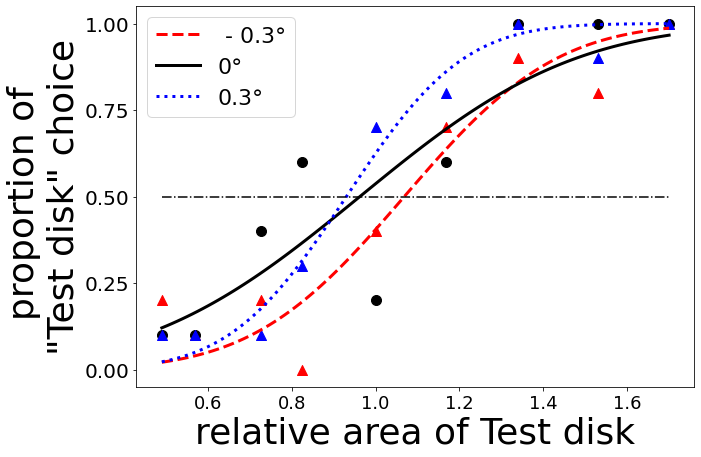

In [10]:
plt.figure(figsize=(10, 7))
plt.scatter(TestDisk_radius_arr, selected_prop[0], color='red', marker='^', s=100)
plt.plot(xx, y_fit_0, color='red', linestyle='dashed', label=' - 0.3°',linewidth=3)
plt.scatter(TestDisk_radius_arr, selected_prop[1], color='black', s=100)
plt.plot(xx, y_fit_1, color='black', label='0°',linewidth=3)
plt.scatter(TestDisk_radius_arr, selected_prop[2], color='blue',marker='^', s=100)
plt.plot(xx, y_fit_2, color='blue', linestyle='dotted', label='0.3°',linewidth=3)

plt.plot([np.min(TestDisk_radius_arr), np.max(TestDisk_radius_arr)], [0.5, 0.5], color='black', linestyle='dashdot')
# plt.title('Subject : HY', fontsize=32)
plt.xlabel('relative area of Test disk', fontsize=36)
plt.ylabel('proportion of \n"Test disk" choice', fontsize=36)
# plt.xticks(TestDisk_radius_arr, relative_rr, fontsize=18)

plt.xticks(np.array([0.6, 0.8, 1., 1.2, 1.4, 1.6])*3, [0.6, 0.8, 1., 1.2, 1.4, 1.6], fontsize=18)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=20)
plt.legend(fontsize=22)

# PSEシフトのプロット

In [14]:
def linear(xx, a, b):
    yy = a*xx + b
    return yy

D = 53  # 視距離[cm]
I = 6.5 # 眼間距離[cm]
stimDiam = 6 # 刺激の大きさ[deg]
S = D*np.tan(stimDiam*np.pi/180) # 視距離53cm，刺激の大きさ6°のときの刺激の大きさ[cm]

disparity = np.array([-0.3, 0, 0.3]) # 両眼視差
xx = np.linspace(-0.3, 0.31, 30)

theta = np.arctan(I/2 / D) * 180/np.pi  # 視距離53cm，眼間距離6.25cm，両眼視差0°の時の対象までの視角

dist = np.zeros(len(disparity))
angle = np.zeros(len(disparity))
for ii in range(len(disparity)):
    dist[ii] = I/2 / np.tan((theta-disparity[ii])*np.pi/180)
    angle[ii] = np.arctan(S/dist[ii]) * 180/np.pi

measuredAngle = np.array(PSE_shift)*2
print(measuredAngle/6)

# fitting
init_param = [-1, 1]
fit_param, cov = curve_fit(linear, disparity, measuredAngle, p0=init_param)
y_fit = linear(xx, fit_param[0], fit_param[1])

[1.06839985 0.96244966 0.93031428]


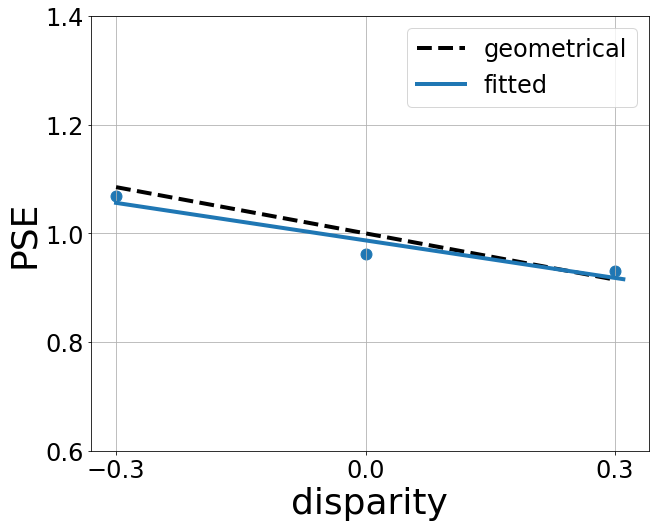

In [17]:
plt.figure(figsize=(10,8))
# plt.plot(disparity, dist)
plt.plot(disparity, angle, color='black', label='geometrical', linewidth=4, linestyle='--')

plt.plot(xx, y_fit, label='fitted', linewidth=4)
# plt.plot(disparity, measuredAngle, label='mesured', linewidth=4)
plt.scatter(disparity, measuredAngle, s=120)

# plt.title('PSE shift subject:HY', fontsize=32)
plt.xlabel('disparity', fontsize=36); plt.ylabel('PSE', fontsize=36)
yaxis_angle = np.arange(0.6, 1.61, 0.2)*6
plt.xticks(disparity, fontsize=24); plt.yticks(yaxis_angle, np.round(yaxis_angle/6, 2), fontsize=24)
plt.ylim(0.6*6, 1.4*6)
plt.grid()
plt.legend(fontsize=24)